# Instacart Modeling Subsample

**Training and evaluation with multiple classification models on a subsample of the Instacart dataset**  

In [65]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
import patsy
import sys
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import psycopg2 as pg
import pandas.io.sql as pd_sql

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, log_loss, confusion_matrix, roc_curve, roc_auc_score

from helper_functions import plot_features, get_user_split_data, scale_transform

In [129]:
# reload updated module
importlib.reload(sys.modules['helper_functions'])
from helper_functions import plot_features, get_user_split_data, scale_transform

In [2]:
# establish connection to instacart database
connection_args = {
    'host': 'localhost',  # enter PUBLIC IP address of AWS instance here - '3.16.165.24'
    #'user': 'ubuntu',    # enter username on AWS - 'ubuntu'
    'dbname': 'instacart',    # DB that we are connecting to
    'port': 5432,             # port we opened on AWS
}

connection = pg.connect(**connection_args)

OperationalError: FATAL:  database "instacart" does not exist


In [4]:
# test out a sample query
query = "SELECT * FROM order_products_prior_view LIMIT 5;"

pd_sql.read_sql(query, connection)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,12427,3,0,1,prior,1,2,08,None
1,2539329,14084,2,0,1,prior,1,2,08,None
2,2539329,196,1,0,1,prior,1,2,08,None
3,2539329,26088,4,0,1,prior,1,2,08,None
4,2539329,26405,5,0,1,prior,1,2,08,None


In [ ]:
# run below queries from instacart db and store output into dataframes

# query from order products prior view (joined on order products prior and orders table)
query_order_products_prior = """
    SELECT * FROM order_products_prior_sample_view 
"""

# query from order products train view (joined on order products train and orders table)
query_order_products_train = """
    SELECT * FROM order_products_train_sample_view 
"""

# query from products table
query_products = """
    SELECT * FROM products
"""

# query from departments table
query_departments = """
    SELECT * FROM departments
"""

# query from aisles table
query_aisles = """
    SELECT * FROM aisles 
"""

df_order_products_prior = pd_sql.read_sql(query_order_products_prior, connection)
df_order_products_train = pd_sql.read_sql(query_order_products_train, connection)
df_products = pd_sql.read_sql(query_products, connection)
df_departments = pd_sql.read_sql(query_departments, connection)
df_aisles = pd_sql.read_sql(query_aisles, connection)

In [10]:
# info and head of products prior dataframe
df_order_products_prior.info()
df_order_products_prior.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798358 entries, 0 to 798357
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                798358 non-null  object
 1   product_id              798358 non-null  object
 2   add_to_cart_order       798358 non-null  int64 
 3   reordered               798358 non-null  int64 
 4   user_id                 798358 non-null  object
 5   eval_set                798358 non-null  object
 6   order_number            798358 non-null  object
 7   order_dow               798358 non-null  object
 8   order_hour_of_day       798358 non-null  object
 9   days_since_prior_order  747923 non-null  object
dtypes: int64(2), object(8)
memory usage: 60.9+ MB


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1994250,10895,31,0,28950,prior,1,4,09,None
1,1994250,11023,43,0,28950,prior,1,4,09,None
2,1994250,13176,10,0,28950,prior,1,4,09,None
3,1994250,13431,32,0,28950,prior,1,4,09,None
4,1994250,141,29,0,28950,prior,1,4,09,None


In [11]:
# info and head of products train dataframe
df_order_products_train.info()
df_order_products_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33873 entries, 0 to 33872
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                33873 non-null  object
 1   product_id              33873 non-null  object
 2   add_to_cart_order       33873 non-null  int64 
 3   reordered               33873 non-null  int64 
 4   user_id                 33873 non-null  object
 5   eval_set                33873 non-null  object
 6   order_number            33873 non-null  object
 7   order_dow               33873 non-null  object
 8   order_hour_of_day       33873 non-null  object
 9   days_since_prior_order  33873 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,9776,35221,1,1,142322,train,21,3,14,6.0
1,9776,42078,2,1,142322,train,21,3,14,6.0
2,9776,30218,3,1,142322,train,21,3,14,6.0
3,9776,22700,4,0,142322,train,21,3,14,6.0
4,9776,13260,5,0,142322,train,21,3,14,6.0


In [15]:
# create a user-product aggregated version of the order_products_prior data, aggregating on total # of times a user ordered a product
df_user_product = (df_order_products_prior.groupby(['product_id','user_id'], as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(train_ids)] #this excludes test users from kaggle

df_X.head()

,product_id,user_id,user_product_total_orders
0,1,101727,6
3,1,15172,1
4,1,15182,32
5,1,161636,3
6,1,169929,1


In [161]:
# shape of dataframe
df_X.shape

(208606, 3)

In [16]:
# add new column as the set of products that exist in the user's latest cart
train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}"
1,10310,101727,24,"{43352, 21873, 45051, 38928, 18615, 11759}"
2,10498,101727,2,"{43352, 21873, 45051, 38928, 18615, 11759}"
3,10509,101727,7,"{43352, 21873, 45051, 38928, 18615, 11759}"
4,11266,101727,22,"{43352, 21873, 45051, 38928, 18615, 11759}"


In [17]:
# create in cart as binary variable, 1 as product in cart and 0 as product not in cart
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0
1,10310,101727,24,"{43352, 21873, 45051, 38928, 18615, 11759}",0
2,10498,101727,2,"{43352, 21873, 45051, 38928, 18615, 11759}",0
3,10509,101727,7,"{43352, 21873, 45051, 38928, 18615, 11759}",0
4,11266,101727,22,"{43352, 21873, 45051, 38928, 18615, 11759}",0


0    0.902055
1    0.097945
Name: in_cart, dtype: float64


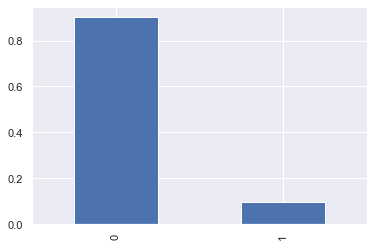

In [617]:
# let's see how imbalanced the classes are in this subsample
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

In [33]:
# pickle dataframe
df_X.to_pickle('instacart_df_X.pkl')

In [50]:
# read pickle
df_X = pd.read_pickle('instacart_df_X.pkl')

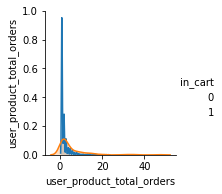

In [54]:
# plot pairplot on features
plot_features(df_X)

# Logistic Regression model

**Baseline score using F1 metric:**

In [104]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=['user_product_total_orders'], 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model 
lr = LogisticRegression() 
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

0.09828823854224185

In [37]:
# coefficient of feature
lr.coef_

array([[0.14878338]])

In [38]:
# info of dataframe
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208606 entries, 0 to 208605
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product_id                 208606 non-null  object
 1   user_id                    208606 non-null  object
 2   user_product_total_orders  208606 non-null  int64 
 3   latest_cart                208606 non-null  object
 4   in_cart                    208606 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 9.5+ MB


## Product features
* Total count of orders across all users
* Average add_to_cart_order
* Probability of reorder relative to total order volume

In [63]:
# head of dataframe
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2494809,16145,10,0,20306,prior,1,0,20,NaN
1,2494809,18594,20,0,20306,prior,1,0,20,NaN
2,2494809,18908,4,0,20306,prior,1,0,20,NaN
3,2494809,21405,19,0,20306,prior,1,0,20,NaN
4,2494809,24852,8,0,20306,prior,1,0,20,NaN


In [20]:
# create product-specific features
prod_features = ['product_total_orders', 'product_avg_add_to_cart_order', 'product_reorder_prob']

df_prod_features = df_order_products_prior.groupby(['product_id'], as_index=False).agg(
    {'order_id': 'nunique', 'add_to_cart_order': 'mean', 'reordered': 'mean'})
df_prod_features.columns = ['product_id'] + prod_features
df_prod_features.head()

,product_id,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob
0,1,60,4.316667,0.733333
1,10,67,7.417910,0.417910
2,100,2,11.000000,0.500000
3,1000,85,8.482353,0.576471
4,10004,4,4.500000,0.750000


In [21]:
# merge product-specific features with df x
df_X = df_X.merge(df_prod_features, on='product_id')
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0,60,4.316667,0.733333
1,1,15172,1,"{42736, 30731, 44987, 9837}",0,60,4.316667,0.733333
2,1,15182,32,"{1, 30731, 19511, 4210}",1,60,4.316667,0.733333
3,1,161636,3,"{3039, 35277, 3262, 13920}",0,60,4.316667,0.733333
4,1,169929,1,"{49141, 35619, 24852, 40310}",0,60,4.316667,0.733333


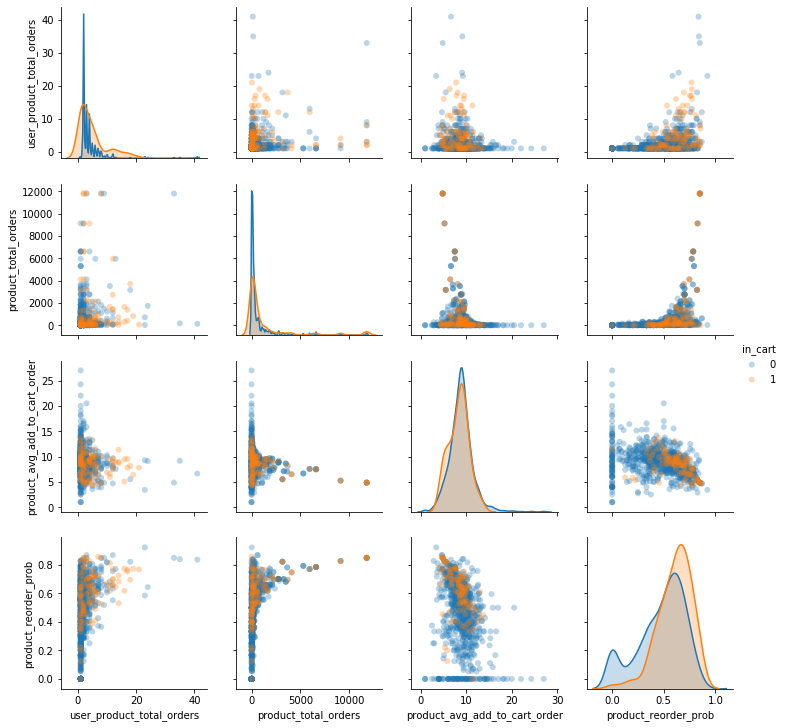

In [67]:
# plot pairplot of features
plot_features(df_X)

In [68]:
# info of dataframe
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208606 entries, 0 to 208605
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     208606 non-null  object 
 1   user_id                        208606 non-null  object 
 2   user_product_total_orders      208606 non-null  int64  
 3   latest_cart                    208606 non-null  object 
 4   in_cart                        208606 non-null  int64  
 5   product_total_orders           208606 non-null  int64  
 6   product_avg_add_to_cart_order  208606 non-null  float64
 7   product_reorder_prob           208606 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 14.3+ MB


In [22]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=['product_total_orders', 
                                                   'product_avg_add_to_cart_order', 
                                                   'product_reorder_prob'], 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model
lr = LogisticRegression()
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

0.09882460344630835

## User features
* Total # of orders
* Average cart size
* Average # of days since prior order
* Probability of reordering 

In [23]:
# convert data types of some features
df_order_products_prior['days_since_prior_order'] = pd.to_numeric(df_order_products_prior['days_since_prior_order'], errors='coerce')

df_order_products_prior.order_number = df_order_products_prior.order_number.astype(int)
df_order_products_prior.reordered = df_order_products_prior.reordered.astype(int)
df_order_products_prior.order_dow = df_order_products_prior.order_dow.astype(int)
df_order_products_prior.order_hour_of_day = df_order_products_prior.order_hour_of_day.astype(int)

In [24]:
# create user-specific features
user_features = ['user_total_orders', 'user_avg_cart_size', 'user_avg_days_since_prior', 'user_reorder_prob']

df_user_features = df_order_products_prior.groupby('user_id', as_index=False).agg({
    'order_id':['nunique', lambda x: x.shape[0]/x.nunique()],
    'days_since_prior_order':'mean',
    'reordered':'mean'})

df_user_features.columns = ['user_id'] + user_features
df_user_features.head()

,user_id,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob
0,100047,8,9.250000,2.350000,0.581081
1,100083,3,14.666667,14.448276,0.272727
2,100118,14,18.428571,9.390041,0.829457
3,100137,7,3.142857,28.842105,0.681818
4,100188,13,7.307692,16.238636,0.652632


In [25]:
# merge user-specific features with df x  
df_X = df_X.merge(df_user_features, on='user_id')
df_X = df_X.dropna()
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0,60,4.316667,0.733333,34,15.058824,7.917004,0.902344
1,10310,101727,24,"{43352, 21873, 45051, 38928, 18615, 11759}",0,101,5.960396,0.811881,34,15.058824,7.917004,0.902344
2,10498,101727,2,"{43352, 21873, 45051, 38928, 18615, 11759}",0,24,8.541667,0.291667,34,15.058824,7.917004,0.902344


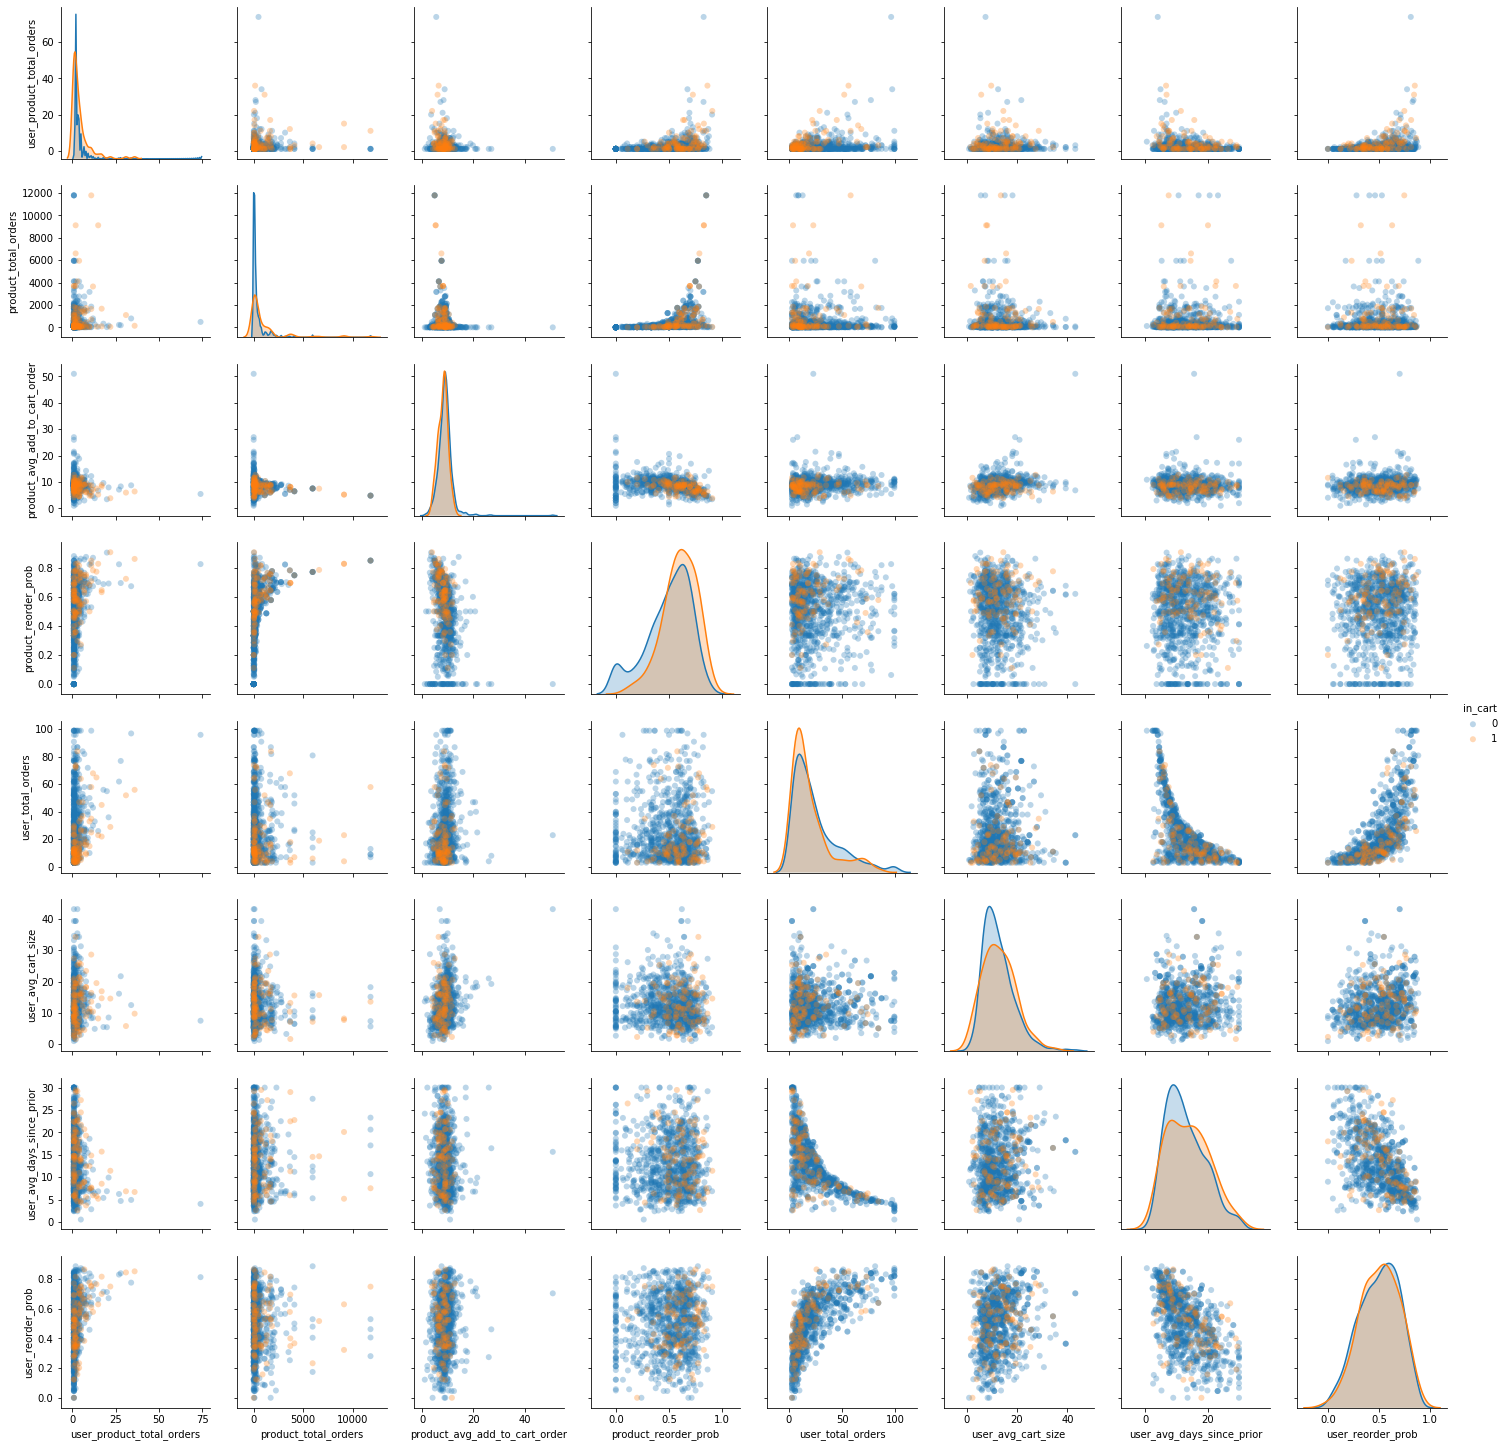

In [79]:
# plot pairplot of features
plot_features(df_X)

In [26]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=['user_total_orders', 
                                                   'user_avg_cart_size', 
                                                   'user_avg_days_since_prior', 
                                                   'user_reorder_prob'], 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

0.13333333333333333

## User-Product features
* Number of orders with the product for a user
* Probability of product in an order for a user
* Average days since prior purchase of product by user
* Average add to cart order of product by user
* Average day of week of product purchased by user
* Average hour of day of product purchased by user
* Product purchased by user in the previous order
* Product purchased by user two orders ago
* Product purchased by user three orders ago
* Product purchased by user in each of the previous three orders
* Product purchased by user in at least one of the previous three orders

In [20]:
# head of order products prior
df_order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1994250,10895,31,0,28950,prior,1,4,9,NaN
1,1994250,11023,43,0,28950,prior,1,4,9,NaN
2,1994250,13176,10,0,28950,prior,1,4,9,NaN
3,1994250,13431,32,0,28950,prior,1,4,9,NaN
4,1994250,141,29,0,28950,prior,1,4,9,NaN


In [19]:
# head of order products train
df_order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,9776,35221,1,1,142322,train,21,3,14,6.0
1,9776,42078,2,1,142322,train,21,3,14,6.0
2,9776,30218,3,1,142322,train,21,3,14,6.0
3,9776,22700,4,0,142322,train,21,3,14,6.0
4,9776,13260,5,0,142322,train,21,3,14,6.0


In [27]:
# create user-product-specific features
user_prod_features = ['user_product_reorder_prob',
                      'user_product_avg_days_since_last_order',
                      'user_product_avg_add_to_cart_order',
                      'user_product_order_dow',
                      'user_product_order_hour_of_day']

df_user_prod_features = df_order_products_prior.groupby(
    ['user_id', 'product_id'], as_index=False).agg({'reordered':'mean',
                                                    'days_since_prior_order':'mean',
                                                    'add_to_cart_order':'mean',
                                                    'order_dow':'mean',
                                                    'order_hour_of_day':'mean'})

df_user_prod_features.columns = ['user_id', 'product_id'] + user_prod_features
df_user_prod_features.head(3)

,user_id,product_id,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day
0,100047,10385,0.00,NaN,12.0,5.0,15.0
1,100047,11005,0.75,1.666667,7.0,3.0,16.5
2,100047,1194,0.80,3.250000,6.0,3.2,11.8


In [28]:
# merge user-product-specific features with df x
df_X = df_X.merge(df_user_prod_features, on=['user_id', 'product_id'])
df_X = df_X.dropna()
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0,60,4.316667,0.733333,34,15.058824,7.917004,0.902344,0.833333,6.000000,10.166667,4.166667,14.166667
1,10310,101727,24,"{43352, 21873, 45051, 38928, 18615, 11759}",0,101,5.960396,0.811881,34,15.058824,7.917004,0.902344,0.958333,7.565217,7.958333,2.375000,14.833333
2,10498,101727,2,"{43352, 21873, 45051, 38928, 18615, 11759}",0,24,8.541667,0.291667,34,15.058824,7.917004,0.902344,0.500000,10.000000,7.000000,3.000000,10.500000


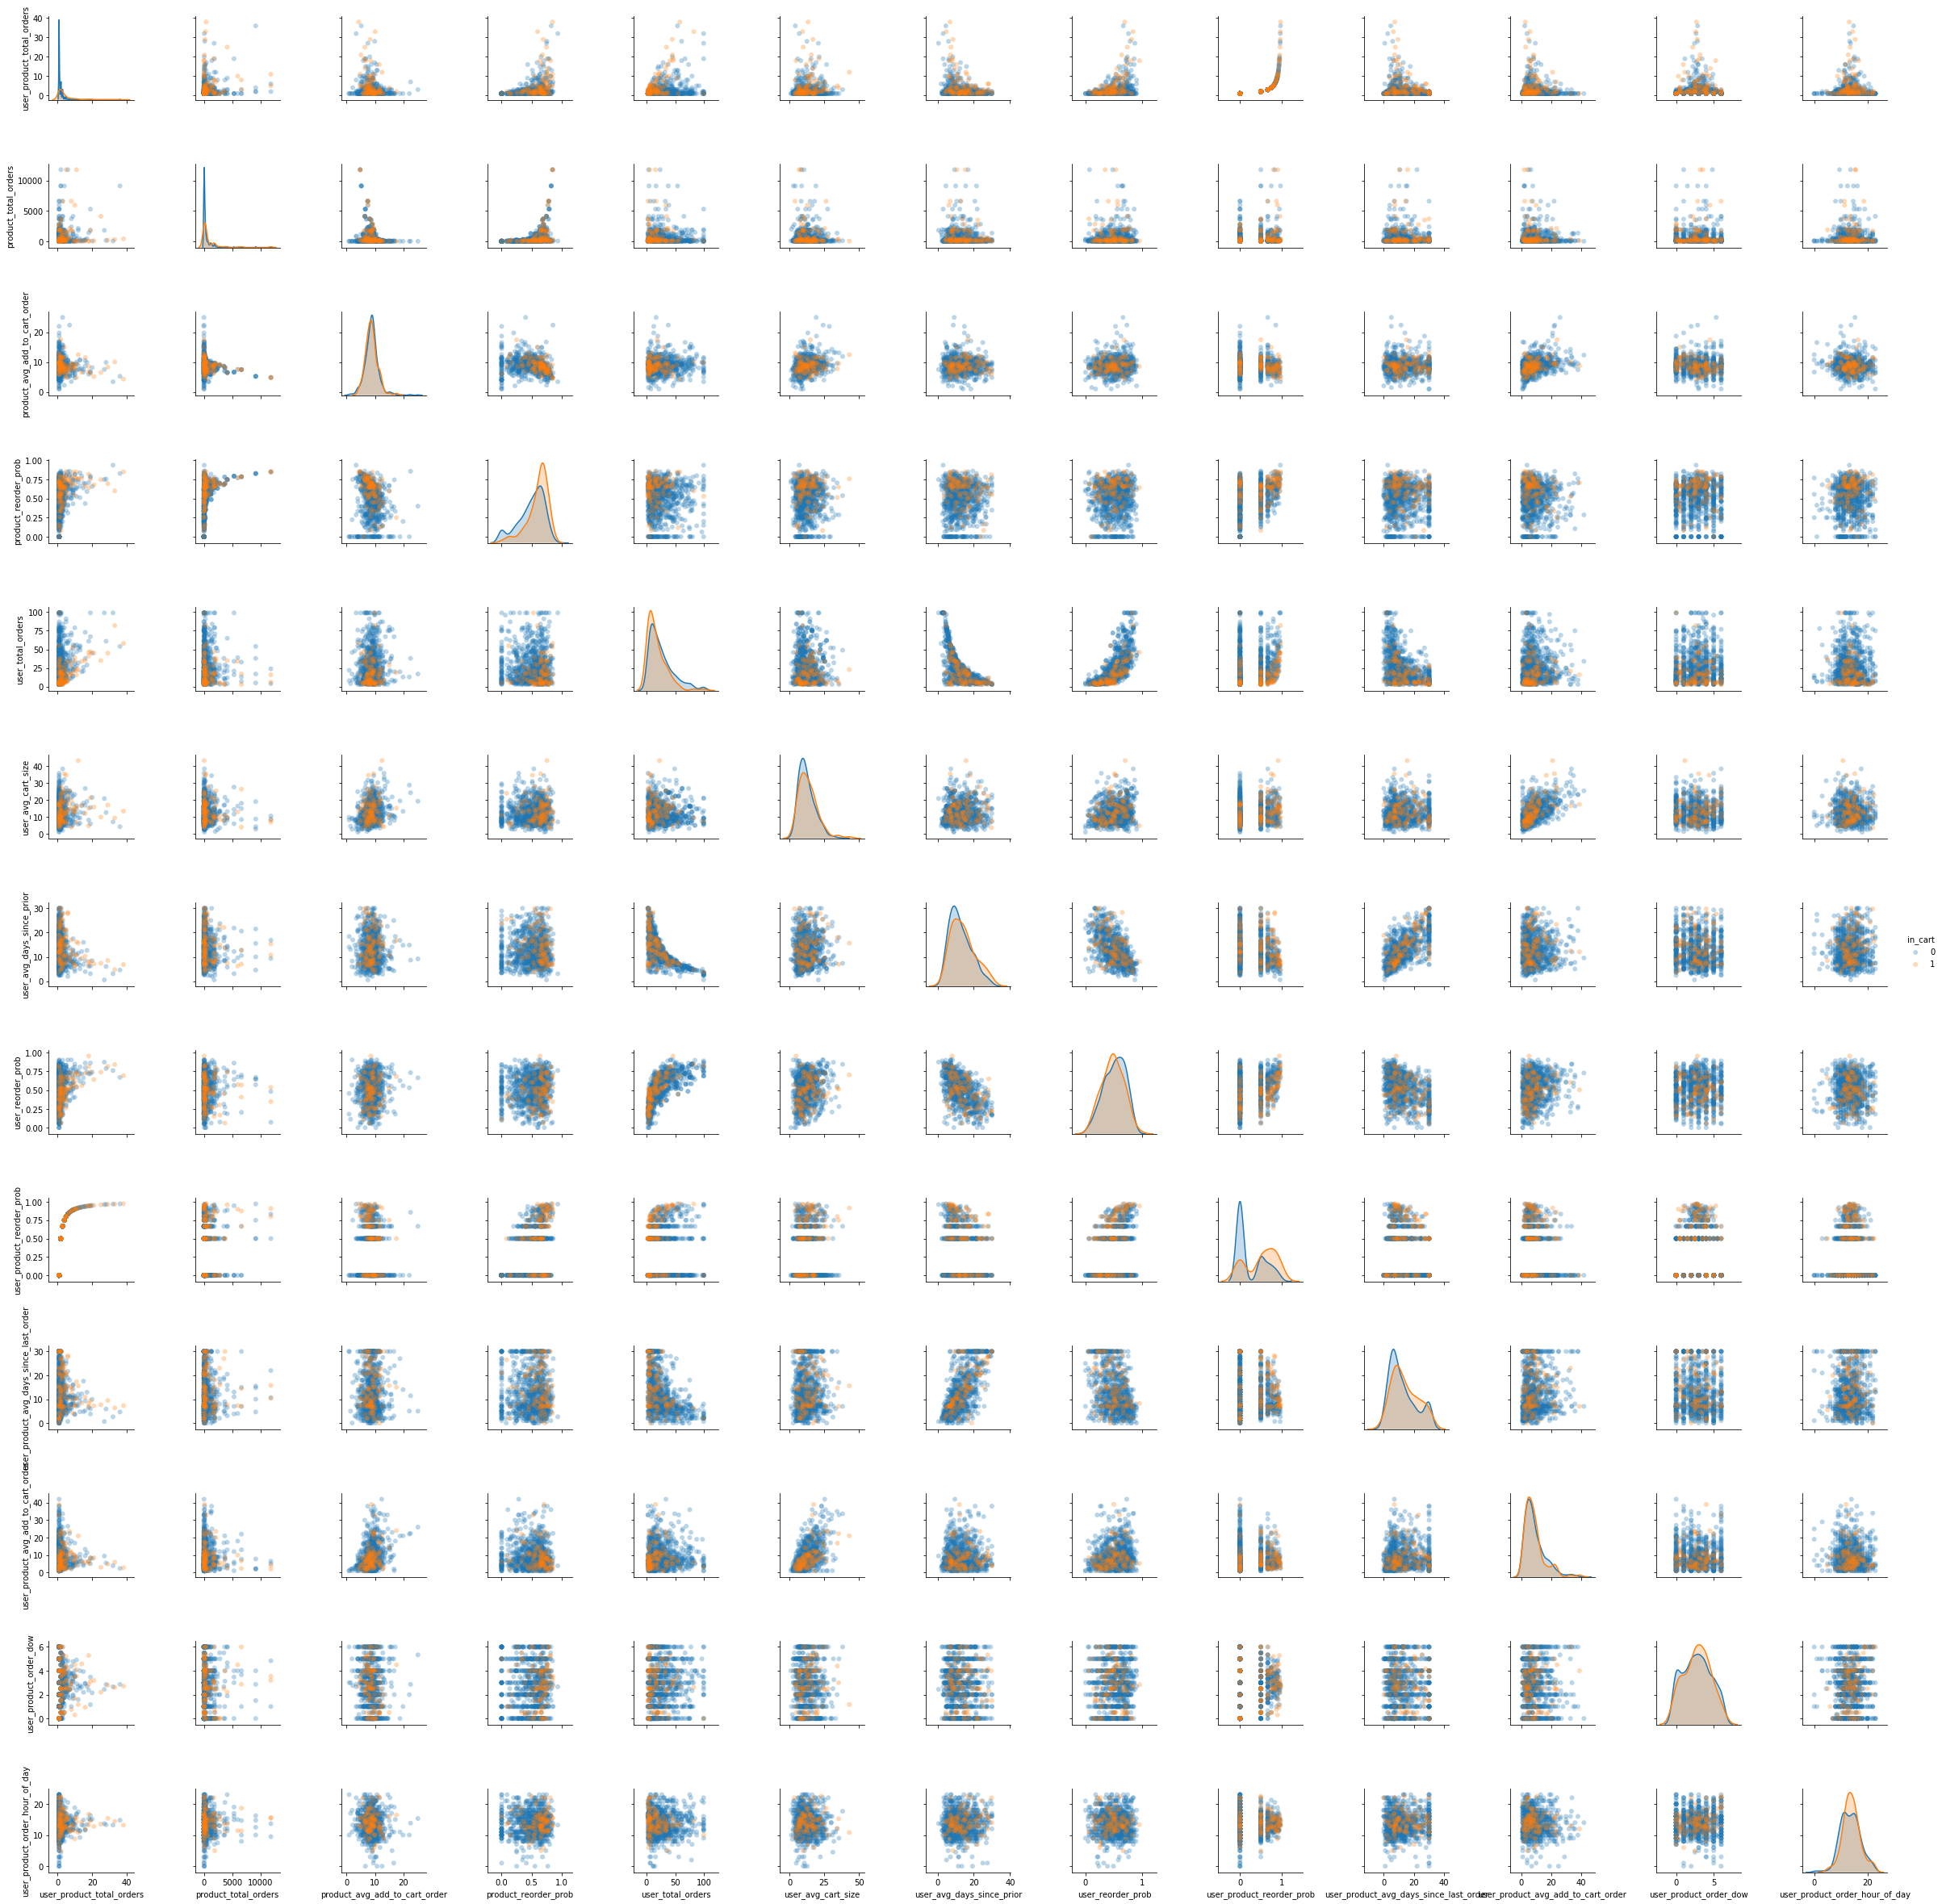

In [88]:
# plot pairplot of features
plot_features(df_X)

In [23]:
# info of df x
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195488 entries, 0 to 208605
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   product_id                              195488 non-null  object 
 1   user_id                                 195488 non-null  object 
 2   user_product_total_orders               195488 non-null  int64  
 3   latest_cart                             195488 non-null  object 
 4   in_cart                                 195488 non-null  int64  
 5   product_total_orders                    195488 non-null  int64  
 6   product_avg_add_to_cart_order           195488 non-null  float64
 7   product_reorder_prob                    195488 non-null  float64
 8   user_product_reorder_prob               195488 non-null  float64
 9   user_product_avg_days_since_last_order  195488 non-null  float64
 10  user_product_avg_add_to_cart_order      1954

In [23]:
# check if there are any null values
df_X.isnull().sum()

product_id                                0
user_id                                   0
user_product_total_orders                 0
latest_cart                               0
in_cart                                   0
product_total_orders                      0
product_avg_add_to_cart_order             0
product_reorder_prob                      0
user_total_orders                         0
user_avg_cart_size                        0
user_avg_days_since_prior                 0
user_reorder_prob                         0
user_product_reorder_prob                 0
user_product_avg_days_since_last_order    0
user_product_avg_add_to_cart_order        0
user_product_order_dow                    0
user_product_order_hour_of_day            0
dtype: int64

In [ ]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=['user_product_reorder_prob',
                                                   'user_product_avg_days_since_last_order',
                                                   'user_product_avg_add_to_cart_order',
                                                   'user_product_order_dow',
                                                   'user_product_order_hour_of_day'], 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

In [94]:
# head of df x
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,user_avg_days_since_prior,user_reorder_prob,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day
0,1,101727,6,"{11759, 43352, 21873, 45051, 38928, 18615}",0,60,4.316667,0.733333,34,15.058824,7.917004,0.902344,0.833333,6.000000,10.166667,4.166667,14.166667
1,10310,101727,24,"{11759, 43352, 21873, 45051, 38928, 18615}",0,101,5.960396,0.811881,34,15.058824,7.917004,0.902344,0.958333,7.565217,7.958333,2.375000,14.833333
2,10498,101727,2,"{11759, 43352, 21873, 45051, 38928, 18615}",0,24,8.541667,0.291667,34,15.058824,7.917004,0.902344,0.500000,10.000000,7.000000,3.000000,10.500000


In [30]:
# head of order products prior
df_order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1994250,10895,31,0,28950,prior,1,4,9,NaN
1,1994250,11023,43,0,28950,prior,1,4,9,NaN
2,1994250,13176,10,0,28950,prior,1,4,9,NaN


In [31]:
# head of order train prior
df_order_products_train.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,9776,35221,1,1,142322,train,21,3,14,6.0
1,9776,42078,2,1,142322,train,21,3,14,6.0
2,9776,30218,3,1,142322,train,21,3,14,6.0


In [33]:
#get max order number for customer in prior orders
max_order_number_prior = df_order_products_prior.groupby(
    ['user_id'], as_index=False).agg({'order_number':'max'}).rename(columns={'order_number':'max_order_number_prior'})

df_user_prod_features_recent = df_order_products_prior.merge(max_order_number_prior, on='user_id')

In [63]:
# head of user product features recent
df_user_prod_features_recent.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,max_order_number_prior
0,1994250,10895,31,0,28950,prior,1,4,9,NaN,40
1,1994250,11023,43,0,28950,prior,1,4,9,NaN,40
2,1994250,13176,10,0,28950,prior,1,4,9,NaN,40
3,1994250,13431,32,0,28950,prior,1,4,9,NaN,40
4,1994250,141,29,0,28950,prior,1,4,9,NaN,40


In [34]:
# product purchased by user in the previous order (max order number in prior set)
df_user_prod_features_recent['user_product_in_one_order_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 0, 1, 0)

# product purchased by user two orders ago
df_user_prod_features_recent['user_product_in_two_orders_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 1, 1, 0)

# product purchased by user three orders ago
df_user_prod_features_recent['user_product_in_three_orders_ago'] = np.where(
    df_user_prod_features_recent['max_order_number_prior'] - 
    df_user_prod_features_recent['order_number'] == 2, 1, 0)

In [35]:
# aggregate by user id and product id
df_user_prod_features_recent = df_user_prod_features_recent.groupby(
    ['user_id', 'product_id'], as_index=False).agg({'user_product_in_one_order_ago':'max',
                                                   'user_product_in_two_orders_ago':'max',
                                                   'user_product_in_three_orders_ago':'max'})

# product purchased by user in all previous three orders
df_user_prod_features_recent['user_product_in_all_previous_three_orders'] = np.where(
    (df_user_prod_features_recent['user_product_in_one_order_ago'] == 1) &
    (df_user_prod_features_recent['user_product_in_two_orders_ago'] == 1) &
    (df_user_prod_features_recent['user_product_in_three_orders_ago'] == 1),  1, 0)

# product purchased by user in at least one of previous three orders
df_user_prod_features_recent['user_product_in_at_least_one_of_previous_three_orders_ago'] = np.where(
    (df_user_prod_features_recent['user_product_in_one_order_ago'] == 1) |
    (df_user_prod_features_recent['user_product_in_two_orders_ago'] == 1) |
    (df_user_prod_features_recent['user_product_in_three_orders_ago'] == 1),  1, 0)

In [83]:
# head of user product features recent
df_user_prod_features_recent.head(5)

,user_id,product_id,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago
0,100047,10385,0,0,0,0,0
1,100047,11005,0,0,1,0,1
2,100047,1194,1,1,0,0,1
3,100047,12206,0,1,1,0,1
4,100047,14405,0,0,0,0,0


In [36]:
# merge user product features recent with df x
df_X = df_X.merge(df_user_prod_features_recent, on=['user_id', 'product_id'])
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,user_product_reorder_prob,user_product_avg_days_since_last_order,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0,60,4.316667,0.733333,34,15.058824,...,0.833333,6.000000,10.166667,4.166667,14.166667,0,0,0,0,0
1,10310,101727,24,"{43352, 21873, 45051, 38928, 18615, 11759}",0,101,5.960396,0.811881,34,15.058824,...,0.958333,7.565217,7.958333,2.375000,14.833333,1,1,0,0,1
2,10498,101727,2,"{43352, 21873, 45051, 38928, 18615, 11759}",0,24,8.541667,0.291667,34,15.058824,...,0.500000,10.000000,7.000000,3.000000,10.500000,0,0,0,0,0


In [37]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=[user_product_in_one_order_ago,                                                                                user_product_in_two_orders_ago, 
                                                   user_product_in_three_orders_ago,               
                                                   user_product_in_all_previous_three_orders, 
                                                  user_product_in_at_least_one_of_previous_three_orders_ago], 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

0.2710935120316783

**Add department / aisle information as categorical features**

In [38]:
# head of df products
df_products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [39]:
# head of df departments
df_departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [40]:
# head of df aisles
df_aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [41]:
# merge product, department and aisle
df_prod_dept_aisle = df_products.merge(df_departments, on='department_id')
df_prod_dept_aisle = df_prod_dept_aisle.merge(df_aisles, on='aisle_id')

In [42]:
# head of df prod dept aisle
df_prod_dept_aisle.head(3)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes


In [43]:
# merge product, department and aisle with df x as categorical features
df_X = df_X.merge(df_prod_dept_aisle[['department', 'aisle', 'product_id']], on='product_id')
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,user_product_avg_add_to_cart_order,user_product_order_dow,user_product_order_hour_of_day,user_product_in_one_order_ago,user_product_in_two_orders_ago,user_product_in_three_orders_ago,user_product_in_all_previous_three_orders,user_product_in_at_least_one_of_previous_three_orders_ago,department,aisle
0,1,101727,6,"{43352, 21873, 45051, 38928, 18615, 11759}",0,60,4.316667,0.733333,34,15.058824,...,10.166667,4.166667,14.166667,0,0,0,0,0,snacks,cookies cakes
1,1,15172,1,"{42736, 30731, 44987, 9837}",0,60,4.316667,0.733333,60,2.800000,...,4.000000,5.000000,11.000000,0,0,0,0,0,snacks,cookies cakes
2,1,15182,32,"{1, 30731, 19511, 4210}",1,60,4.316667,0.733333,79,2.772152,...,2.843750,2.937500,15.031250,0,0,1,0,1,snacks,cookies cakes


In [44]:
# dummify categorical features
df_X = pd.get_dummies(df_X, prefix=['dept', 'aisle'], columns=['department', 'aisle']) 

In [132]:
# head of df x
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,1,101727,6,"{45051, 21873, 43352, 18615, 38928, 11759}",0,60,4.316667,0.733333,34,15.058824,...,0,0,0,0,0,0,0,0,0,0
1,1,15172,1,"{44987, 30731, 9837, 42736}",0,60,4.316667,0.733333,60,2.800000,...,0,0,0,0,0,0,0,0,0,0
2,1,15182,32,"{1, 19511, 4210, 30731}",1,60,4.316667,0.733333,79,2.772152,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# split into train/val/test by users
X_train, X_val, X_test, y_train, y_val, y_test = get_user_split_data(df_X)

# scale based on train, then transform train/val/test
X_train, X_val, X_test = scale_transform(features=list(df_X.columns[22:]), 
                                         X_train=X_train, X_val=X_val, X_test=X_test)

# fit and evaluate model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
f1_score(lr.predict(X_val), y_val)

0.26798334785555233

**Address class imbalance via threshold adjustment to optimize F1:**

Logistic Regression Model best F1 score 0.44042 at prob decision threshold >= 0.231


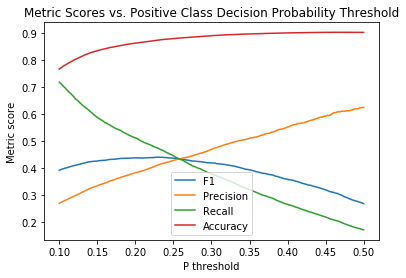

In [177]:
# calculate and plot evaluation metrics from logistic regression model on x val across probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model with best F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

plt.savefig('Metric scores.png')

ROC AUC score =  0.8210192733869381


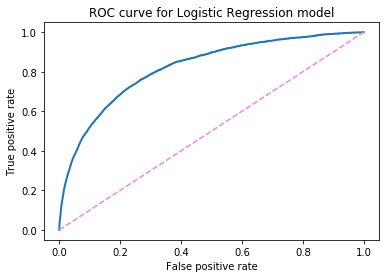

In [186]:
# calculate and plot roc curve for logistic regression model
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic Regression model')
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]))

plt.savefig('ROC AUC score.png')

## Error Analysis on predictions from validation data 

In [ ]:
# create new dataframe that joins together the original df_X with our y predictions (non-predicted rows will be excluded in the new dataframe)
y_pred = (lr.predict_proba(X_val)[:, 1] >= 0.231).astype(int)
df_X_pred = df_X.iloc[X_val.index]
df_X_pred['prediction'] = y_pred

In [ ]:
# add a column that outputs whether our prediction matches with actual target
df_X_pred['prediction_matches'] = np.where(df_X_pred.in_cart == df_X_pred.prediction, 1, 0)

In [107]:
# merge in department, aisle and product name for more details
df_X_pred = df_X_pred.merge(df_prod_dept_aisle[[
                            'product_name', 'department', 'aisle', 'product_id']], on='product_id')

In [108]:
# check out what we predicted wrong on a random user
df_X_pred[df_X_pred.user_id == '15182']

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_reorder_prob,user_total_orders,user_avg_cart_size,...,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,prediction,prediction_matches,product_name,department,aisle
0,1,15182,32,"{1, 4210, 30731, 19511}",1,60,4.316667,0.733333,79,2.772152,...,0,0,0,0,0,0,0,Chocolate Sandwich Cookies,snacks,cookies cakes
1096,30731,15182,45,"{1, 4210, 30731, 19511}",1,93,4.795699,0.698925,79,2.772152,...,0,0,0,0,0,1,1,Pure Cane Granulated White Sugar,pantry,baking ingredients
1373,4210,15182,75,"{1, 4210, 30731, 19511}",1,878,4.796128,0.777904,79,2.772152,...,0,0,0,0,0,1,1,Whole Milk,dairy eggs,milk
1789,26612,15182,1,"{1, 4210, 30731, 19511}",0,5,2.400000,0.200000,79,2.772152,...,1,0,0,0,0,0,1,Extra Strong Large Trash 30 Gallon Drawstring ...,household,trash bags liners
1791,10255,15182,1,"{1, 4210, 30731, 19511}",0,53,6.018868,0.264151,79,2.772152,...,0,0,0,0,0,0,1,Clean Care Mega Rolls Toilet Paper,household,paper goods
1802,18339,15182,9,"{1, 4210, 30731, 19511}",0,119,7.596639,0.310924,79,2.772152,...,0,0,0,0,0,0,1,100% Lemon Juice,beverages,juice nectars
1822,19511,15182,50,"{1, 4210, 30731, 19511}",1,154,5.811688,0.753247,79,2.772152,...,0,0,0,0,0,1,1,Half And Half,dairy eggs,cream
1832,22318,15182,2,"{1, 4210, 30731, 19511}",0,6,5.333333,0.166667,79,2.772152,...,0,0,0,0,0,0,1,Sweetened Dried Cranberries,snacks,nuts seeds dried fruit
1833,24166,15182,1,"{1, 4210, 30731, 19511}",0,3,1.666667,0.000000,79,2.772152,...,0,0,0,0,0,0,1,Extra Heavy Mayonaise,pantry,condiments
1834,36431,15182,1,"{1, 4210, 30731, 19511}",0,107,8.476636,0.616822,79,2.772152,...,0,0,0,0,0,0,1,Hardwood Smoked Bacon,meat seafood,hot dogs bacon sausage


**Correctly predicted 10 out of 11 products for user 15182!**

# Tree-based models

## Random Forest model

In [385]:
# instantiate, fit and predict using random forest
rf = RandomForestClassifier(n_estimators = 200) #n_estimators = 100    
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [386]:
# calculate evaluation metrics 
f_score = f1_score(y_val, y_pred)
acc_score = rf.score(X_val, y_val)
prec_score = precision_score(y_val, y_pred)
rec_score = recall_score(y_val, y_pred)

print("Random Forest performance:")
print("F1: {:6.5f}".format(f_score))    
print("Accuracy: {:6.5f}".format(acc_score))
print("Precision: {:6.5f}".format(prec_score))
print("Recall: {:6.5f}".format(rec_score))

Random Forest performance:
F1: 0.21603
Accuracy: 0.90193
Precision: 0.64997
Recall: 0.12955


Random Forest Model with best F1 score 0.42841 at prob decision threshold >= 0.210


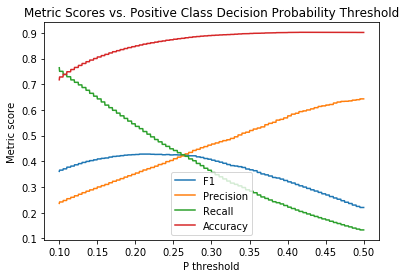

In [389]:
# calculate and plot evaluation metrics from random forest model on x val across probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = rf.predict_proba(X_val)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Model with best F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

ROC AUC score =  0.8118211605449214


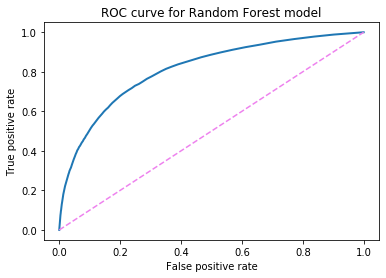

In [391]:
# calculate and plot roc curve for random forest model
fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr, lw = 2)
plt.plot([0,1], [0,1], c = 'violet', ls = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Random Forest model');
print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

plt.savefig('ROC AUC score.png')

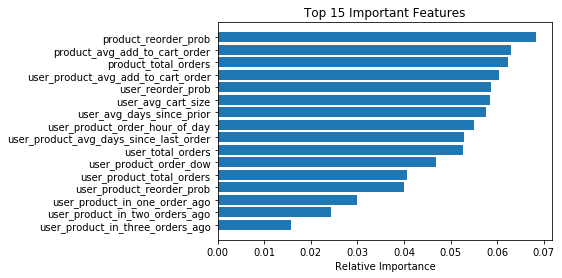

In [392]:
# plot important features 
features = X_train.columns
importances = rf.feature_importances_[:16]
indices = np.argsort(importances)

plt.title('Top 15 Important Features')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Gradient Boosting model

In [32]:
# instantiate and fit gradient boosting model
gb = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=8, #10-0.242, 3-0.241, 9-0.246 8-0.255
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=0.8, #1-0.255, 0.9-0.251, 0.8-0.243, 0.5-0.246
                        min_child_weight=12, #1-0.251, 5-0.260, 10-0.261, 15-0.260, #12-0.263
                        colsample_bytree=.7 #0.8-0.242, 0.5-0.253, 0.7-0.254
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gb.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    #eval_metric=xgb_f1,
                    eval_metric='logloss', 
                    early_stopping_rounds=50,
                    verbose=True
                   )

[0]	validation_0-logloss:0.65843	validation_1-logloss:0.65919
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.62669	validation_1-logloss:0.62857
[2]	validation_0-logloss:0.59790	validation_1-logloss:0.60062
[3]	validation_0-logloss:0.57163	validation_1-logloss:0.57519
[4]	validation_0-logloss:0.54726	validation_1-logloss:0.55169
[5]	validation_0-logloss:0.52523	validation_1-logloss:0.53037
[6]	validation_0-logloss:0.50484	validation_1-logloss:0.51073
[7]	validation_0-logloss:0.48608	validation_1-logloss:0.49274
[8]	validation_0-logloss:0.46888	validation_1-logloss:0.47621
[9]	validation_0-logloss:0.45319	validation_1-logloss:0.46113
[10]	validation_0-logloss:0.43849	validation_1-logloss:0.44709
[11]	validation_0-logloss:0.42473	validation_1-logloss:0.43401
[12]	validation_0-logloss:0.41200	validation_1-logloss:0.42191
[13]	validation_0-logloss:

[128]	validation_0-logloss:0.20381	validation_1-logloss:0.26128
[129]	validation_0-logloss:0.20365	validation_1-logloss:0.26130
[130]	validation_0-logloss:0.20336	validation_1-logloss:0.26132
[131]	validation_0-logloss:0.20317	validation_1-logloss:0.26134
[132]	validation_0-logloss:0.20299	validation_1-logloss:0.26135
[133]	validation_0-logloss:0.20276	validation_1-logloss:0.26131
[134]	validation_0-logloss:0.20254	validation_1-logloss:0.26131
[135]	validation_0-logloss:0.20231	validation_1-logloss:0.26131
[136]	validation_0-logloss:0.20213	validation_1-logloss:0.26135
[137]	validation_0-logloss:0.20197	validation_1-logloss:0.26138
[138]	validation_0-logloss:0.20178	validation_1-logloss:0.26143
[139]	validation_0-logloss:0.20168	validation_1-logloss:0.26144
[140]	validation_0-logloss:0.20146	validation_1-logloss:0.26147
[141]	validation_0-logloss:0.20132	validation_1-logloss:0.26149
[142]	validation_0-logloss:0.20116	validation_1-logloss:0.26151
[143]	validation_0-logloss:0.20111	valid

In [372]:
# calculate f1 score
y_pred = gb.predict(X_val, ntree_limit=gb.best_ntree_limit)
f1_score(y_val, y_pred)

0.2617687610793776

In [373]:
# predict probabilities
y_pred = gb.predict_proba(X_val, ntree_limit=gb.best_ntree_limit)[:,1]
y_pred

array([0.3380402 , 0.04724353, 0.2665676 , ..., 0.13517985, 0.8155657 ,
       0.16695942], dtype=float32)

In [259]:
# predict classes
y_pred = gb.predict(X_val, ntree_limit=gb.best_ntree_limit)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [377]:
# calculate evaluation metrics
f_score = f1_score(y_val, y_pred)
acc_score = gb.score(X_val, y_val)
prec_score = precision_score(y_val, y_pred)
rec_score = recall_score(y_val, y_pred)

print("Gradient Boosting performance:")
print("F1: {:6.5f}".format(f_score))    
print("Accuracy: {:6.5f}".format(acc_score))
print("Precision: {:6.5f}".format(prec_score))
print("Recall: {:6.5f}".format(rec_score))

Gradient Boosting performance:
F1: 0.26177
Accuracy: 0.90363
Precision: 0.65115
Recall: 0.16381


Gradient Boosting Model with best F1 score 0.44272 at prob decision threshold >= 0.210


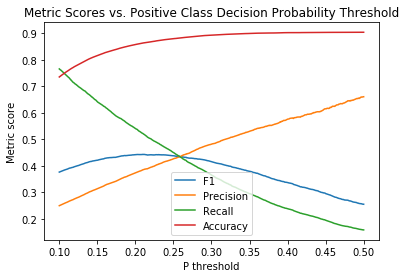

In [318]:
# calculate and plot evaluation metrics from xgboost model on x val across probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = gb.predict_proba(X_val)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Gradient Boosting Model with best F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

plt.savefig('Metric scores.png')

Gradient Boosting Model with best F1 score 0.44360 at prob decision threshold >= 0.218


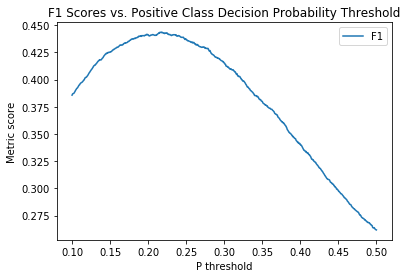

In [393]:
# calculate and plot f1 scores for xgboost model on x val across probability threshold values
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = gb.predict_proba(X_val)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    
plt.plot(thresh_ps, f1_scores)

plt.title('F1 Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1']) 
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Gradient Boosting Model with best F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

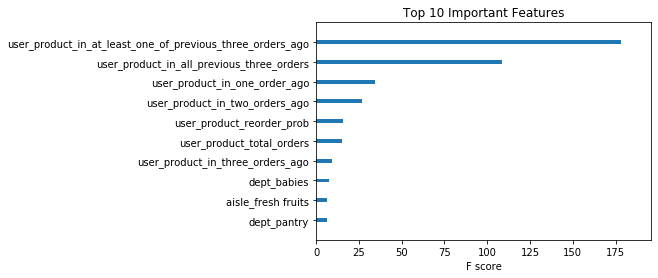

In [381]:
# plot important features
xgb.plot_importance(gb, importance_type='gain', max_num_features=10, grid=False, title='Top 10 Important Features', ylabel=None, show_values=False);

In [ ]:
# calculate and plot roc curve for gradient boosting model
fpr, tpr, thresholds = roc_curve(y_val, gb.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr, lw = 2)
plt.plot([0,1], [0,1], c = 'violet', ls = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Gradient Boosting model');
print("ROC AUC score = ", roc_auc_score(y_val, gb.predict_proba(X_val)[:,1]))

plt.savefig('ROC AUC score.png')

**Plot F1 score vs decision threshold across models**

Logistic Regression model with best F1 score 0.44042 at prob decision threshold >= 0.231
Random Forest model with best F1 score 0.42841 at prob decision threshold >= 0.210
Gradient Boosting model with best F1 score 0.44360 at prob decision threshold >= 0.218


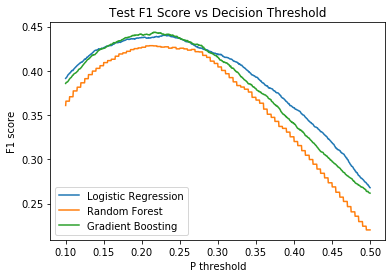

In [387]:
# calculate and plot f1 scores for the three models across probability threshold values 
thresh_ps = np.linspace(.10,.50,1000)
lr_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs
rf_val_probs = rf.predict_proba(X_val)[:,1]
gb_val_probs = gb.predict_proba(X_val)[:,1]

lr_scores, rf_scores, gb_scores = [], [], []

for p in thresh_ps:
    lr_val_labels = lr_val_probs >= p
    rf_val_labels = rf_val_probs >= p
    gb_val_labels = gb_val_probs >= p
    lr_scores.append(f1_score(y_val, lr_val_labels))    
    rf_scores.append(f1_score(y_val, rf_val_labels))    
    gb_scores.append(f1_score(y_val, gb_val_labels))    
    
plt.plot(thresh_ps, lr_scores)
plt.plot(thresh_ps, rf_scores)
plt.plot(thresh_ps, gb_scores)

plt.title('Test F1 Score vs Decision Threshold')
plt.legend(['Logistic Regression','Random Forest', 'Gradient Boosting'])
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_lr_score = np.max(lr_scores) 
best_lr_thresh_p = thresh_ps[np.argmax(lr_scores)]

best_rf_score = np.max(rf_scores) 
best_rf_thresh_p = thresh_ps[np.argmax(rf_scores)]

best_gb_score = np.max(gb_scores) 
best_gb_thresh_p = thresh_ps[np.argmax(gb_scores)]

print('Logistic Regression model with max F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_lr_score, best_lr_thresh_p))

print('Random Forest model with max F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_rf_score, best_rf_thresh_p))

print('Gradient Boosting model with max F1 score %.5f at prob decision threshold >= %.3f' 
      % (best_gb_score, best_gb_thresh_p))

plt.savefig('F1 scores across models.png')

**Make predictions based on class adjusted decision threshold**

In [ ]:
y_pred_new_threshold = (gb.predict_proba(X_test)[:,1] >= 0.218).astype(int)
#decisions = (model.predict_proba() >= mythreshold).astype(int)